In [2]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Correctly using lowercase as per Python naming conventions
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from era_data import TabletPeriodDataset, get_IDS
from VAE_model_tablets_class import VAE

# Hyper Parameters

In [3]:
IMG_DIR = 'output/images_preprocessed'
BATCH_SIZE = 16
VERSION_NAME = 'period_clf_bs8_lr0.0001_beta_1_epochs_30-VAE-94936_samples-masked_w_classification_loss-equalpartsloss-April20_2'
RESNET_VERNAME = 'period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples_preprocessed-masked_April16-80-10-10_train_test_val-2' #reading the same train set and test set as previous modelsIDS = get_IDS(IMG_DIR=IMG_DIR)
IDS = get_IDS(IMG_DIR=IMG_DIR)
print(len(IDS))

94936


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Data

In [5]:
train_ids = pd.read_csv(f'output/clf_ids/period-train-{RESNET_VERNAME}.csv', header=None)[0].astype(str)
val_ids = pd.read_csv(f'output/clf_ids/period-val-{RESNET_VERNAME}.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/period-test-{RESNET_VERNAME}.csv', header=None)[0].astype(str)

In [6]:
ds_train = TabletPeriodDataset(IDS=train_ids, IMG_DIR=IMG_DIR, mask=True)
ds_val = TabletPeriodDataset(IDS=val_ids, IMG_DIR=IMG_DIR, mask=True)
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR, mask=True)

Filtering 94936 IDS down to provided 75948...
Filtering 94936 IDS down to provided 9494...
Filtering 94936 IDS down to provided 9494...


In [7]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES)
num_classes

22

In [8]:
class_weights = torch.load("data/class_weights_period.pt")

In [9]:
! ls lightning_logs/$VERSION_NAME/checkpoints

epoch=18-step=176469.ckpt


In [10]:
def collate_fn(batch):
    data = torch.stack([torch.from_numpy(sample[1]).unsqueeze(0) for sample in batch])
    labels = torch.tensor([sample[2] for sample in batch])

    return data, labels

In [11]:
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn = collate_fn, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn = collate_fn, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn = collate_fn, pin_memory=True)

# Load Model and present sample predictions

In [13]:
chekpoint_path = f'lightning_logs/{VERSION_NAME}/checkpoints/epoch=18-step=176469.ckpt'
vae_model = VAE.load_from_checkpoint(chekpoint_path,image_channels=1,z_dim=12, lr =0.0001, use_classification_loss=True, num_classes=num_classes,
            loss_type="weighted", class_weights=class_weights, device = device)

/sise/mickyfi-group/kapond/AnalysisBySynthesis/VAE_model_tablets_class.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights).to(device)


*****************************************************************************************************************
torch.Size([512, 512])


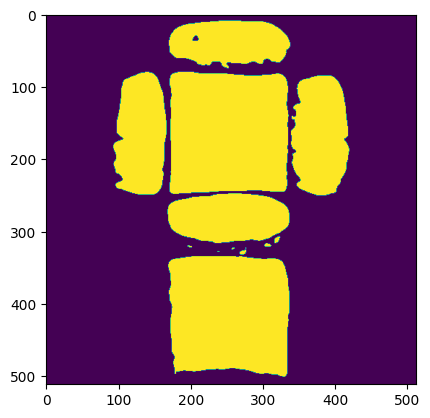

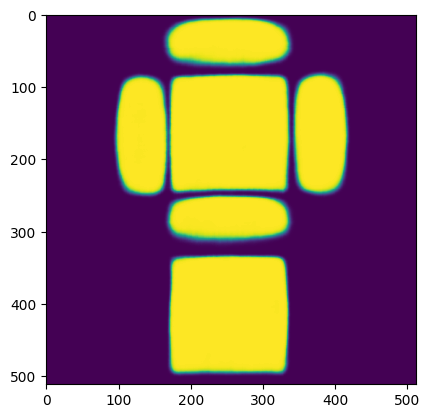

*****************************************************************************************************************
torch.Size([512, 512])


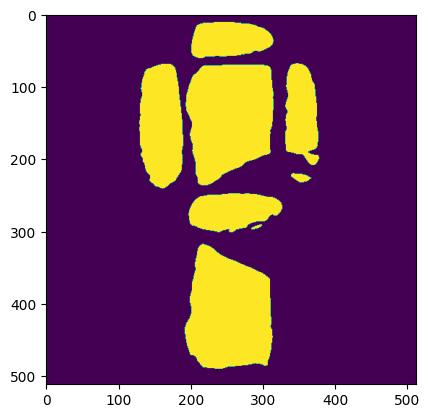

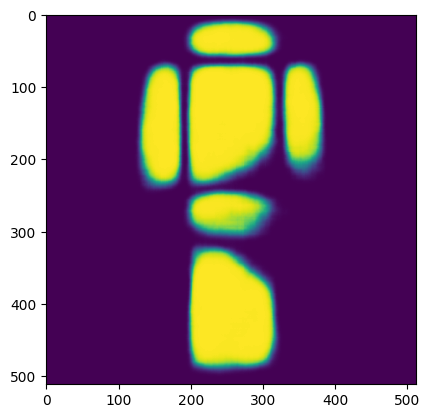

*****************************************************************************************************************
torch.Size([512, 512])


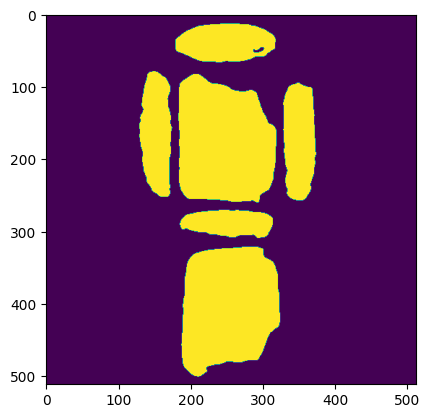

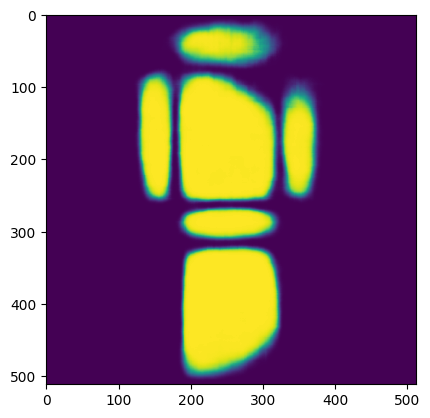

*****************************************************************************************************************
torch.Size([512, 512])


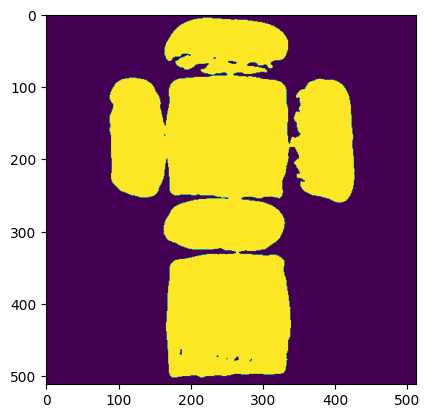

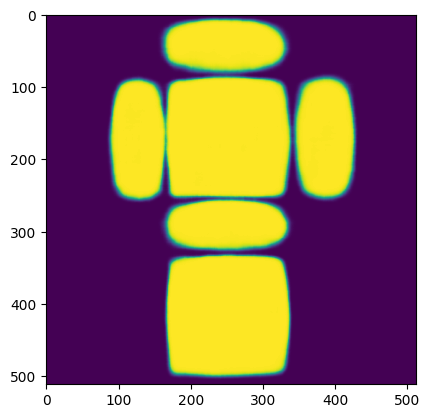

*****************************************************************************************************************
torch.Size([512, 512])


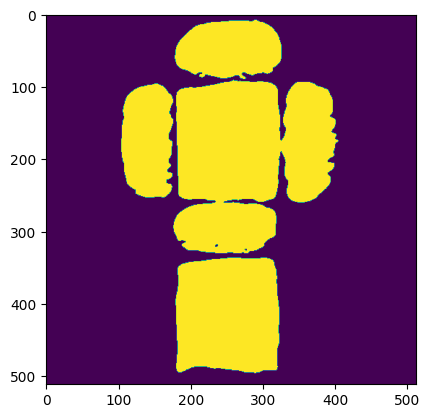

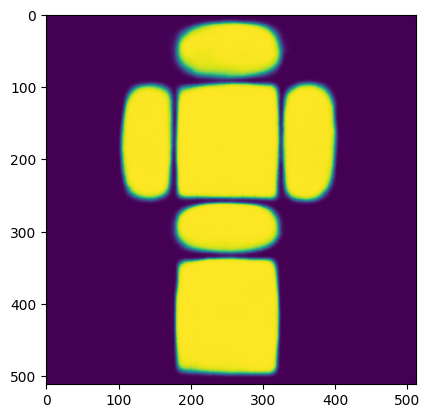

*****************************************************************************************************************
torch.Size([512, 512])


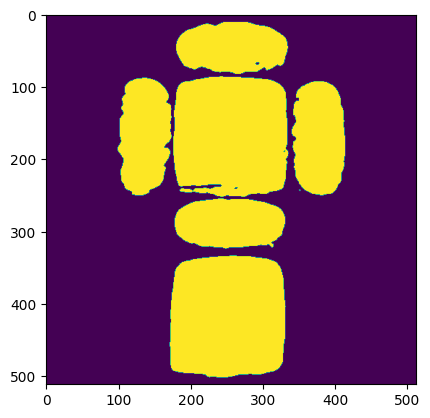

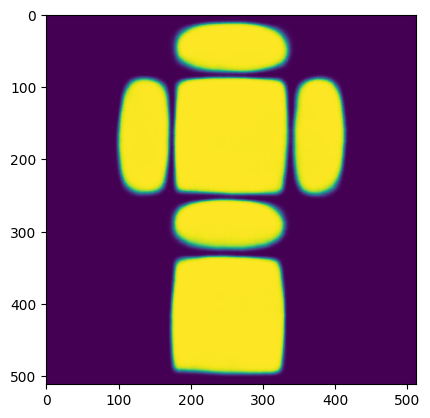

*****************************************************************************************************************
torch.Size([512, 512])


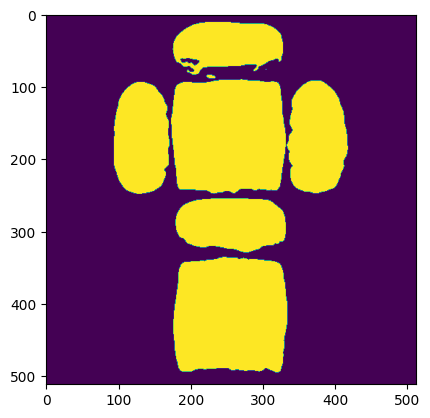

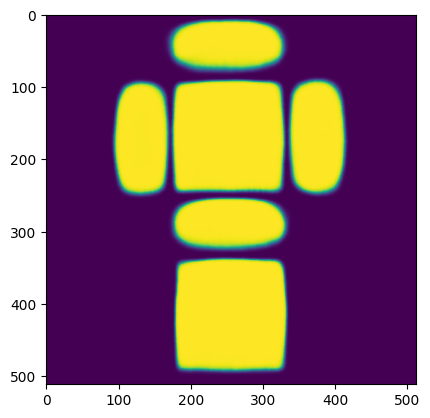

end of epoch 0
*****************************************************************************************************************
torch.Size([512, 512])


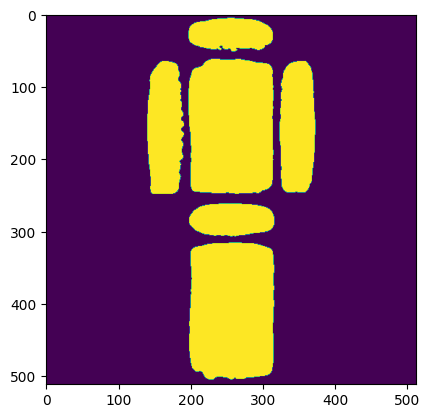

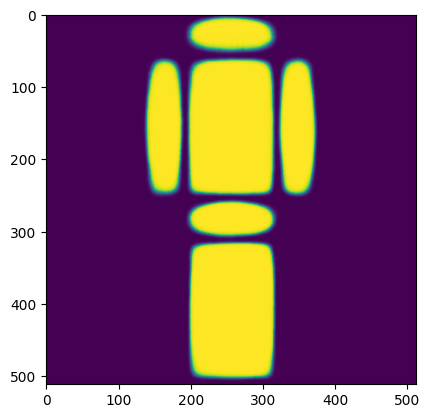

*****************************************************************************************************************
torch.Size([512, 512])


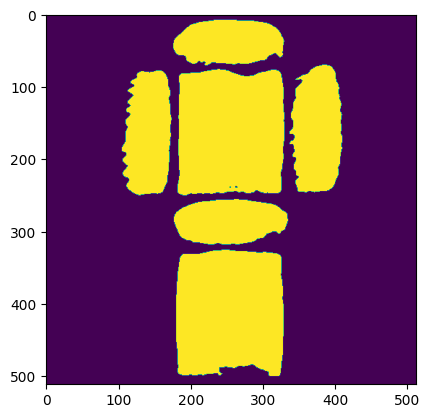

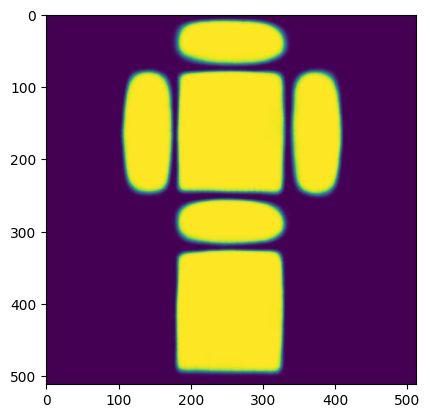

*****************************************************************************************************************
torch.Size([512, 512])


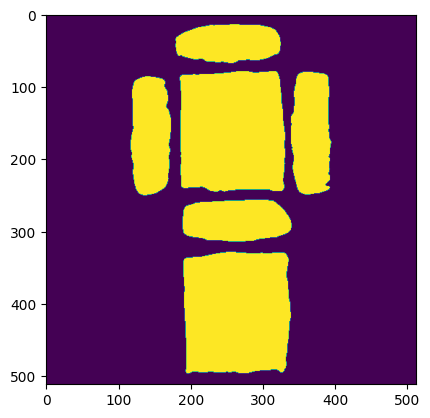

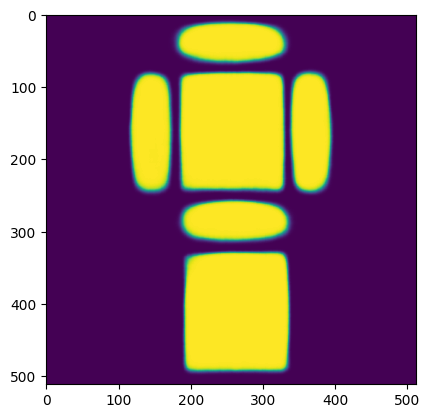

*****************************************************************************************************************
torch.Size([512, 512])


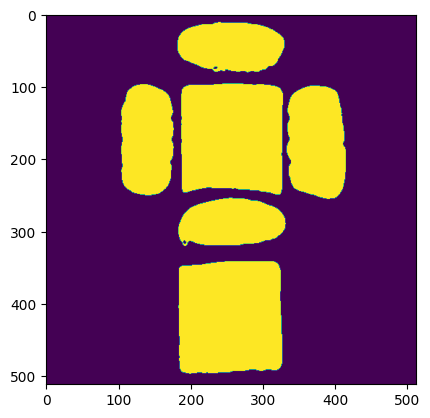

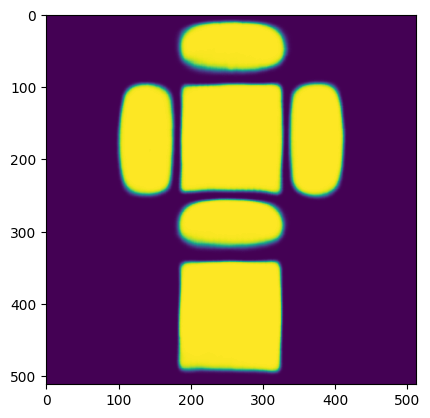

*****************************************************************************************************************
torch.Size([512, 512])


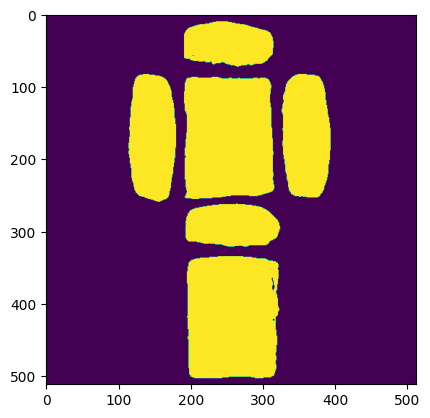

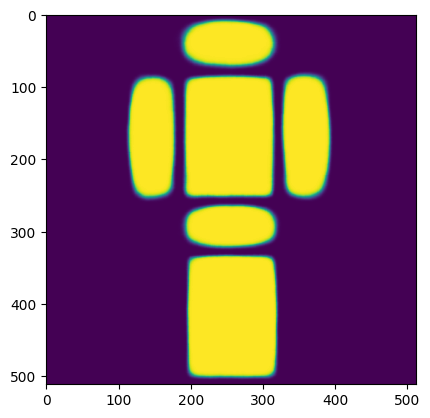

*****************************************************************************************************************
torch.Size([512, 512])


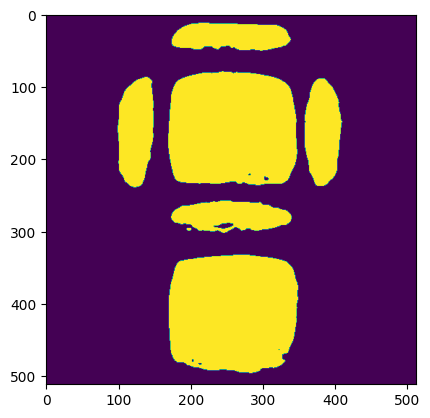

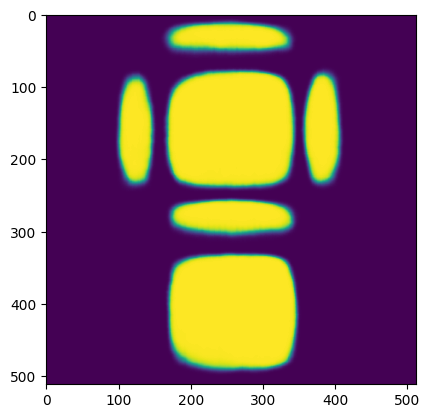

*****************************************************************************************************************
torch.Size([512, 512])


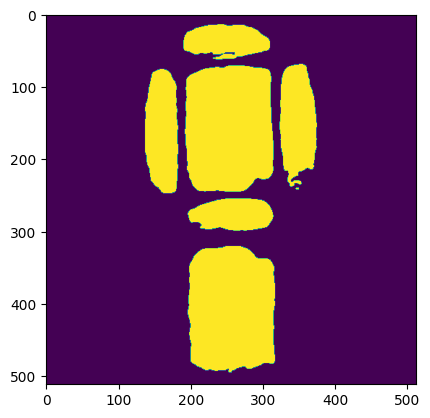

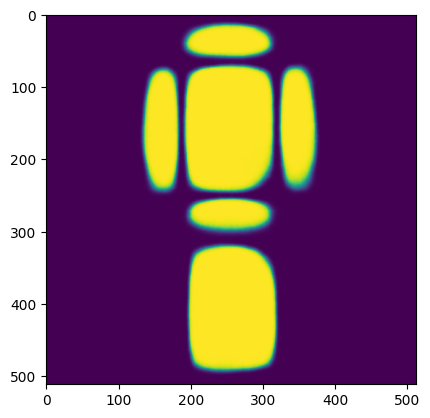

end of epoch 1
*****************************************************************************************************************
torch.Size([512, 512])


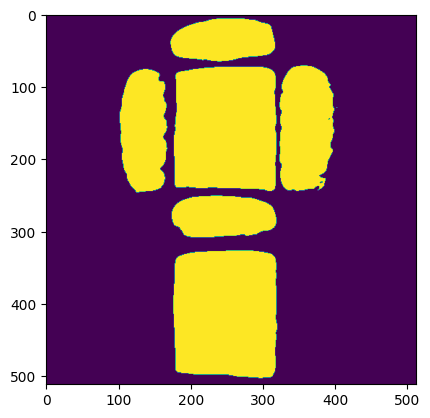

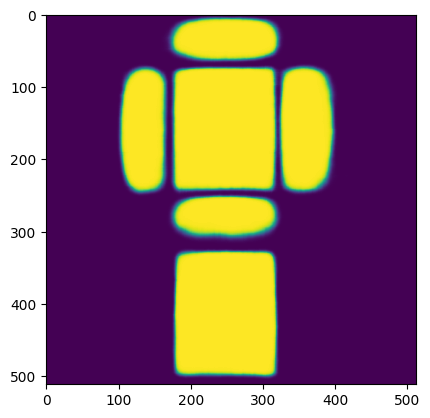

*****************************************************************************************************************
torch.Size([512, 512])


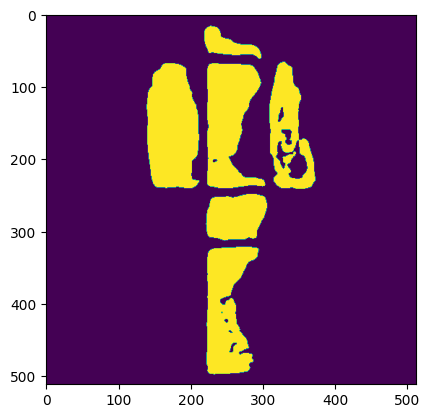

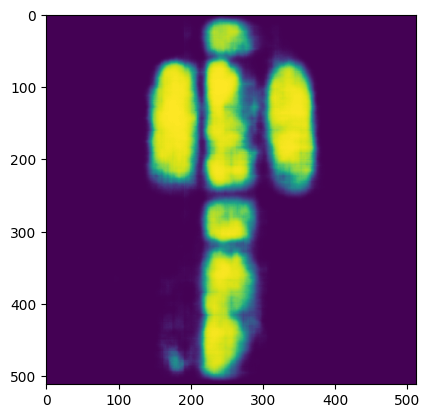

*****************************************************************************************************************
torch.Size([512, 512])


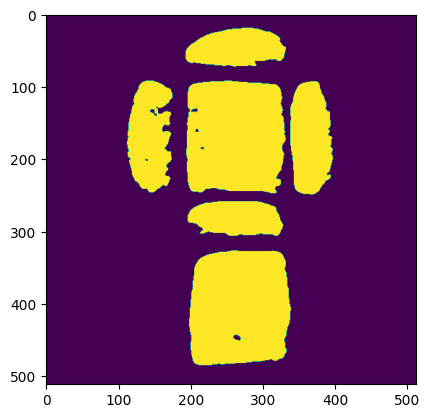

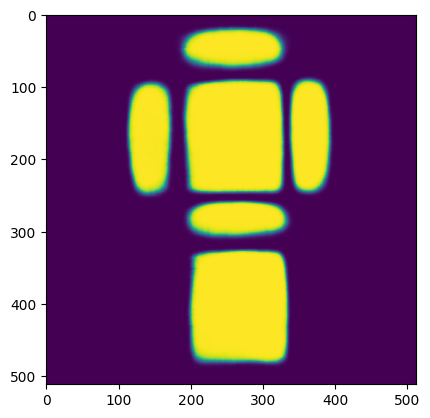

*****************************************************************************************************************
torch.Size([512, 512])


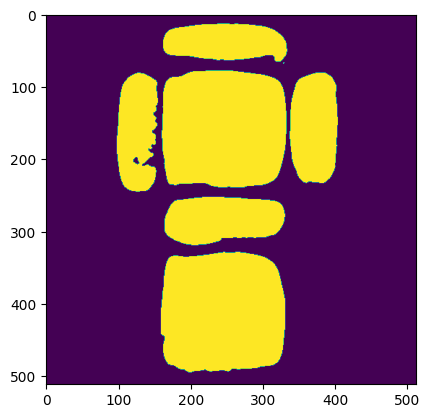

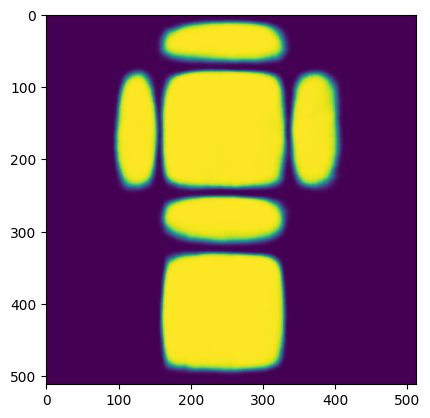

*****************************************************************************************************************
torch.Size([512, 512])


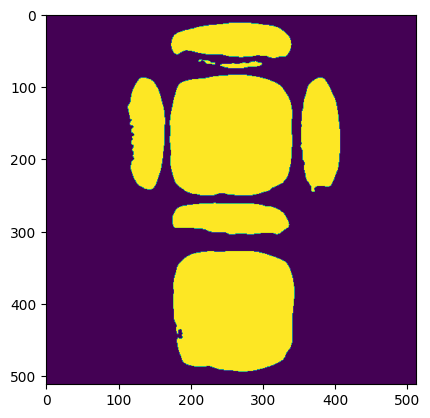

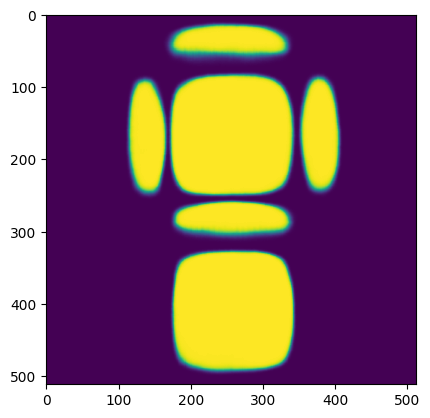

*****************************************************************************************************************
torch.Size([512, 512])


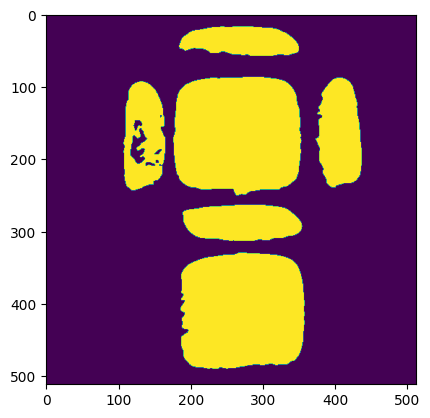

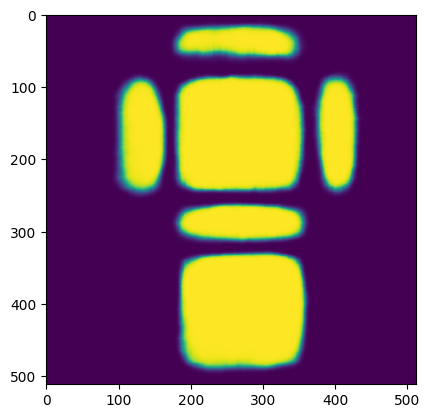

*****************************************************************************************************************
torch.Size([512, 512])


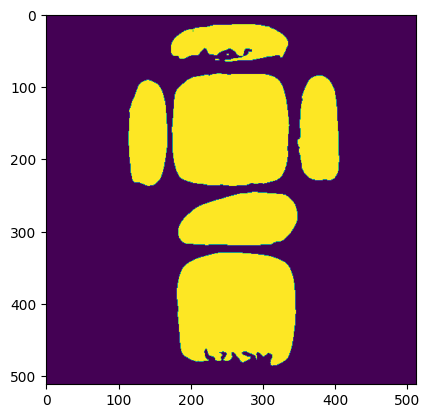

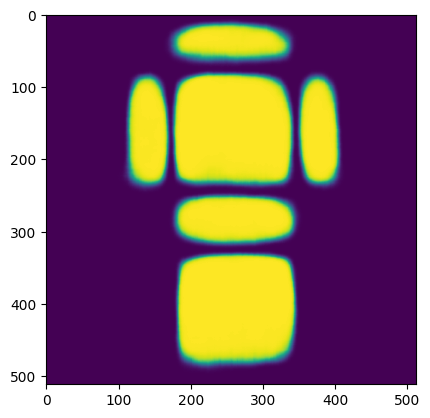

end of epoch 2
*****************************************************************************************************************
torch.Size([512, 512])


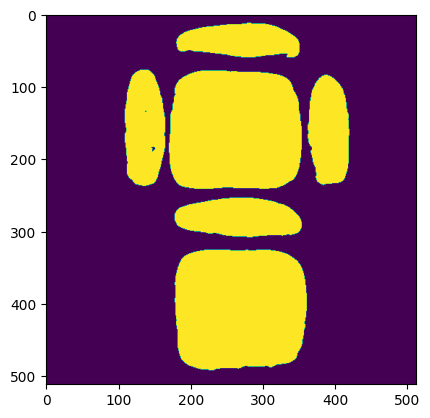

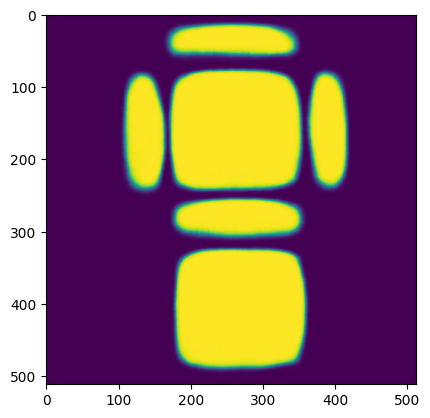

*****************************************************************************************************************
torch.Size([512, 512])


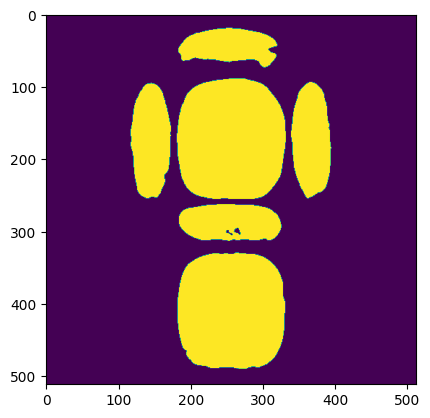

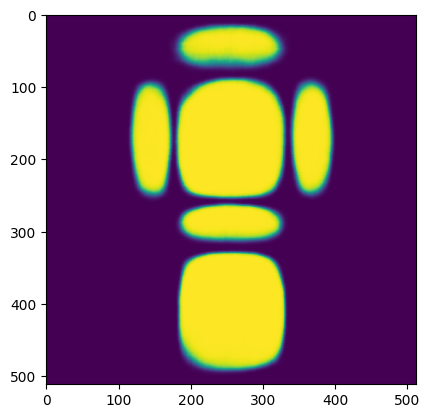

*****************************************************************************************************************



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f02e326cf40> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [14]:
# test:
count = 0
for i, batch in enumerate(dl_test):
    
    for count in range (0, 7):
        print("*****************************************************************************************************************")
        x,y = batch
        plt.imshow(  x[count].permute(1, 2, 0)  )
        plt.figure()
        z = vae_model(x)

        plt.imshow(z[0][count][0].detach())    
        print(z[0][count][0].shape)
        plt.show()
    print("end of epoch "+str(i))
    if i==15:
        break

# Extract sample embeddings from model

In [15]:
def process_batch(batch, vae_model, device):
    cdli_ids, imgs, periods, genres, _ = zip(*batch)

    img_tensors = torch.stack([transforms.ToTensor()(img) for img in imgs]).to(device)

    with torch.no_grad():
        encodings = vae_model.representation(img_tensors)
    encodings = encodings.cpu().numpy()

    return cdli_ids, encodings, periods, genres

In [16]:
def get_encodings_and_labels(dataset, vae_model, device='cuda', batch_size=BATCH_SIZE):
    vae_model.to(device)
    vae_model.eval()

    all_encodings = []
    all_periods = []
    all_genres = []
    all_ids = []
    num_batches = (len(dataset) + batch_size - 1) // batch_size

    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(dataset))
        batch = [dataset[j] for j in range(start_idx, end_idx)]
        cdli_ids, encodings, periods, genres = process_batch(batch, vae_model, device)
        all_ids.extend(cdli_ids)
        all_encodings.extend(encodings)
        all_periods.extend(periods)
        all_genres.extend(genres)

    return np.array(all_ids), np.array(all_encodings), np.array(all_periods), np.array(all_genres)

In [17]:
# Main execution
ids, encodings, periods, genres = get_encodings_and_labels(ds_train, vae_model)

100%|██████████| 4644/4644 [08:48<00:00,  8.80it/s]


In [18]:
# Create dataframe
df = pd.DataFrame(encodings, columns=[f"X{i}" for i in range(1, encodings.shape[1] + 1)])
df['Period'] = periods
df['Genre'] = genres
df['CDLI_id'] = ids

In [19]:
PERIOD_INDICES = {

    0: 'other',
    1: 'Ur III',
    2: 'Neo-Assyrian',
    3: 'Old Babylonian',
    4: 'Middle Babylonian',
    5: 'Neo-Babylonian',
    6: 'Old Akkadian',
    7: 'Achaemenid',
    8: 'Early Old Babylonian',
    9: 'ED IIIb',
    10: 'Middle Assyrian',
    11: 'Old Assyrian',
    12: 'Uruk III',
    13: 'Proto-Elamite',
    14: 'Lagash II',
    15: 'Ebla',
    16: 'ED IIIa',
    17: 'Hellenistic',
    18: 'ED I-II',
    19: 'Middle Elamite',
    20: 'Hittite',
    21: 'Uruk IV'
}

In [20]:
GENRE_INDICES = {
        
        1: 'Administrative',
        2: 'Letter',
        3: 'Legal',
        4: 'Royal/Monumental',
        5: 'Literary',
        6: 'Lexical',
        7: 'Omen',
        8: 'uncertain',
        9: 'School',
        10: 'Mathematical',
        11: 'Prayer/Incantation',
        12: 'Scientific',
        13: 'Ritual',
        14: 'fake (modern)',
        15: 'Astronomical',
        16: 'Private/Votive',
    }

In [21]:
df['Period_Name'] = df['Period'].map(PERIOD_INDICES)

In [22]:
df['Genre_Name'] = df['Genre'].map(GENRE_INDICES)

In [23]:
from datetime import datetime
DATE = datetime.now().strftime("%B%d")

In [24]:
df.to_csv(f"vae_encodings_and_data/vae_encoding_df_{DATE}_w_class_train.csv", index=False)

I will now repeat the process for the test set:

In [25]:
# Main execution
ids_test, encodings_test, periods_test, genres_test = get_encodings_and_labels(ds_test, vae_model)

# Create dataframe
df_test = pd.DataFrame(encodings_test, columns=[f"X{i}" for i in range(1, encodings_test.shape[1] + 1)])
df_test['Period'] = periods_test
df_test['Genre'] = genres_test
df_test['CDLI_id'] = ids_test

100%|██████████| 582/582 [01:35<00:00,  6.12it/s]


In [26]:
df_test['Period_Name'] = df_test['Period'].map(PERIOD_INDICES)
df_test['Genre_Name'] = df_test['Genre'].map(GENRE_INDICES)

In [27]:
df_test.to_csv(f"vae_encodings_and_data/vae_encoding_df_{DATE}_w_class_test.csv", index=False)

In [28]:
ids_val, encodings_val, periods_val, genres_val = get_encodings_and_labels(ds_val, vae_model)

# Create dataframe
df_val = pd.DataFrame(encodings_val, columns=[f"X{i}" for i in range(1, encodings_val.shape[1] + 1)])
df_val['Period'] = periods_val
df_val['Genre'] = genres_val
df_val['CDLI_id'] = ids_val

100%|██████████| 580/580 [01:06<00:00,  8.71it/s]


In [29]:
df_val['Period_Name'] = df_val['Period'].map(PERIOD_INDICES)
df_val['Genre_Name'] = df_val['Genre'].map(GENRE_INDICES)

In [31]:
df_val.to_csv(f"vae_encodings_and_data/vae_encoding_df_{DATE}_w_class_val.csv", index=False)